In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pickle
import os
import re
import random
import json
from pprint import pprint
import gzip

In [202]:
from joblib import Parallel, delayed

In [3]:
font = {'family' : 'Liberation Mono',
        'size'   : 22}

plt.rc('font', **font)

In [4]:
tmstp = '20210105-1528'

In [609]:
numnodes = 16

In [6]:
data_dir = '/home/bglaze/deepgraph/data'
stat_dir = f'{data_dir}/stats/'
param_dir = f'{data_dir}/parameters/'

In [807]:
def get_files(num_nodes):
    file_filter = re.compile(f'^search_stats-numnodes-{num_nodes}.*tmstp-{tmstp}.csv')

    _,_,files = next(os.walk(stat_dir))

    matches= []

    for file in files:
        if file_filter.match(file):
            matches.append(file)

    return matches

In [617]:
# n_steps = int(4e4)

In [618]:
# n_files = 20
# file_sample = random.choices(files, k=n_files)

In [814]:
files = get_files(numnodes)

In [815]:
n_files = len(files)

In [816]:
print(n_files)

80


In [620]:
sample_size = 50000

# Determined using wc on all the stats files for this particular slurm_id
# 8 nodes
# file_length = 410001
# 16 nodes
file_length = 1210001

sample_idxs = range(0,file_length, round(file_length/sample_size))

reward_samples = np.zeros((len(sample_idxs), n_files))
depth_samples = np.zeros((len(sample_idxs), n_files))

In [621]:
params = list()

file_idx = 0
for file in files:
    line_num = 0
    sample_idx = 0
    sample_line_num = sample_idxs[sample_idx]
    print(file_idx, file)
    file_params = re.split('[-_.]', file)
    process = file_params[5]
    repeat = file_params[7]
    params.append((process,repeat, json.load(open(param_dir + f'parameters-numnodes-{numnodes}_process-{process}_repeat-{repeat}_tmstp-{tmstp}.json'))))
    with open(stat_dir+file) as f:
        #skip header
        next(f)
        try:
            for line in f:
                if line_num == sample_line_num:
                    step,depth,reward = line.strip().split(',')
                    reward_samples[sample_idx, file_idx] = reward
                    depth_samples[sample_idx, file_idx] = depth
                    sample_idx = min(len(sample_idxs)-1, sample_idx+1)
                    sample_line_num = sample_idxs[sample_idx]
                line_num += 1
        except Exception as e:
            print(sample_idx, len(sample_idxs), sample_line_num)
            break
        file_idx += 1

0 search_stats-numnodes-16_process-4_repeat-9_tmstp-20210105-1528.csv
1 search_stats-numnodes-16_process-7_repeat-3_tmstp-20210105-1528.csv
2 search_stats-numnodes-16_process-5_repeat-8_tmstp-20210105-1528.csv
3 search_stats-numnodes-16_process-3_repeat-8_tmstp-20210105-1528.csv
4 search_stats-numnodes-16_process-3_repeat-6_tmstp-20210105-1528.csv
5 search_stats-numnodes-16_process-0_repeat-4_tmstp-20210105-1528.csv
6 search_stats-numnodes-16_process-4_repeat-7_tmstp-20210105-1528.csv
7 search_stats-numnodes-16_process-2_repeat-6_tmstp-20210105-1528.csv
8 search_stats-numnodes-16_process-0_repeat-5_tmstp-20210105-1528.csv
9 search_stats-numnodes-16_process-0_repeat-9_tmstp-20210105-1528.csv
10 search_stats-numnodes-16_process-5_repeat-2_tmstp-20210105-1528.csv
11 search_stats-numnodes-16_process-5_repeat-3_tmstp-20210105-1528.csv
12 search_stats-numnodes-16_process-7_repeat-0_tmstp-20210105-1528.csv
13 search_stats-numnodes-16_process-0_repeat-1_tmstp-20210105-1528.csv
14 search_stats-

In [622]:
import matplotlib.colors as mcolors

In [623]:
colors = mcolors.TABLEAU_COLORS
color_keys = list(colors.keys())

In [624]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [625]:
process = 1
repeat = 3

In [626]:
# Pick a random run of the search
# count the number of lines in its log file
i=0
file=random.choice(files)

# file = f'search_stats-numnodes-{numnodes}_process-{process}_repeat-{repeat}_tmstp-20210105-1528.csv'
with open(stat_dir+file) as f:
    for i, l in enumerate(f):
        pass
num_lines = i

# Plot the rewards
rewards = np.zeros((num_lines))

with open(stat_dir+file) as f:
    #skip header
    line_num=0
    next(f)
    for line in f:
        step,depth,reward = line.strip().split(',')
        rewards[line_num] = reward
        line_num += 1
    file_idx += 1

mvavg = moving_average(rewards,10000)

print(file)

search_stats-numnodes-16_process-7_repeat-1_tmstp-20210105-1528.csv


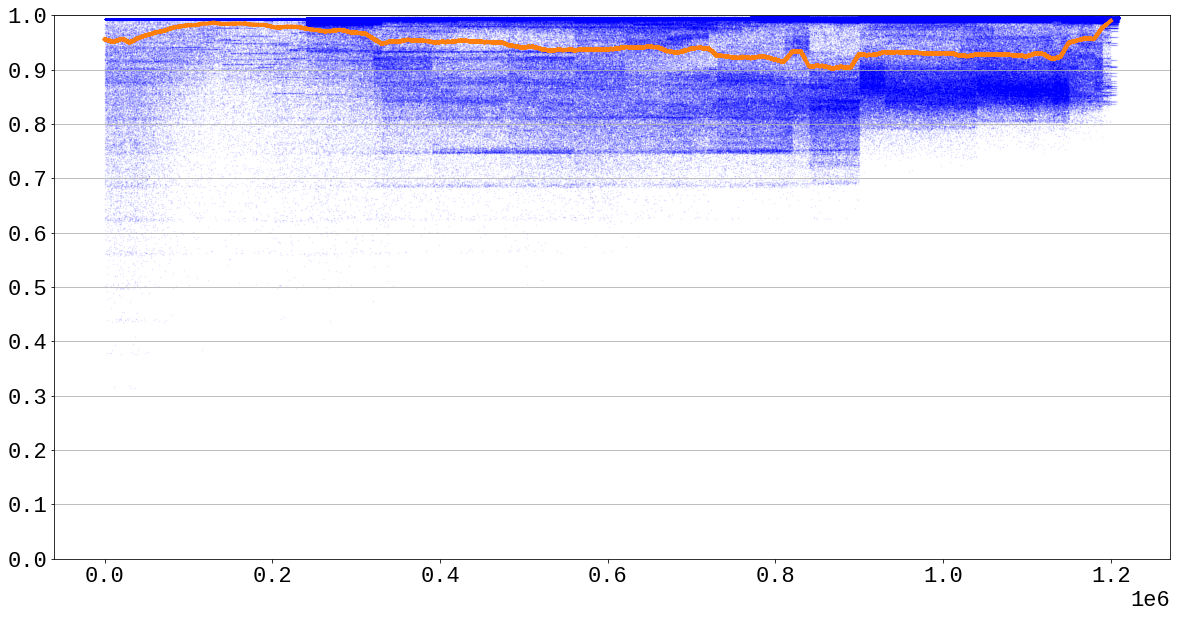

In [627]:
plt.figure(figsize=(20,10))
_=plt.scatter(range(len(rewards)),rewards,
              marker='.',
              s=.8,
              color='blue',
              alpha=.1
             )
_=plt.plot(mvavg, color=colors[color_keys[1]], linewidth=4)
_=plt.yticks(np.arange(0,1.1,.1))
plt.grid(axis='y')
_=plt.ylim([0,1])

## Similarity Progress traces sampled from synthetic data experiments, by hyperparameters

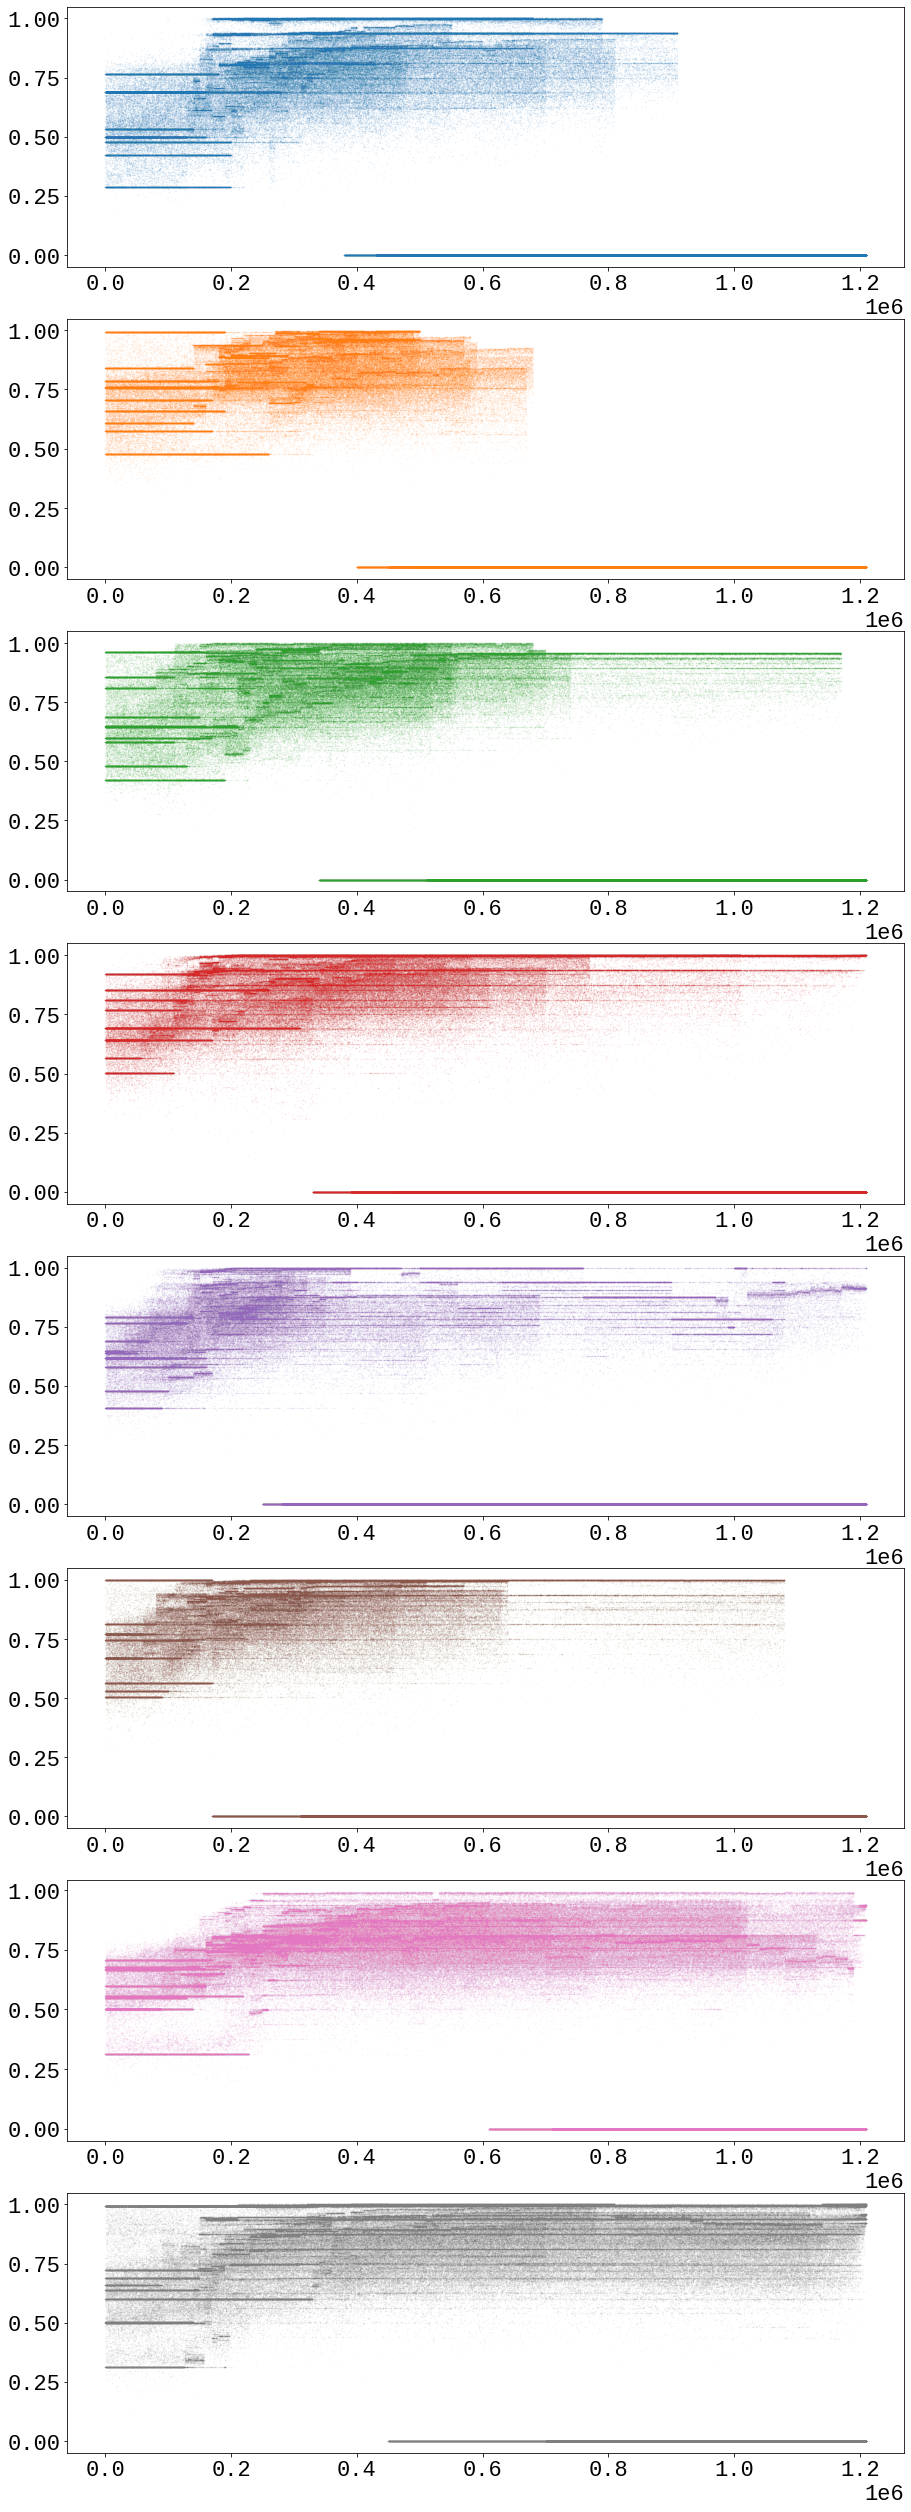

In [24]:
fig, axes = plt.subplots(8, 1, figsize=(15,45))

for i in range(n_files):
    process, repeat, prms = params[i]
    process = int(process)
#     print(process, repeat)
    _=axes[process].scatter(sample_idxs, reward_samples[:,i], 
                  marker='.',
                  s=.5,
                  color=colors[color_keys[int(process)]], 
                  alpha=.1
                 )

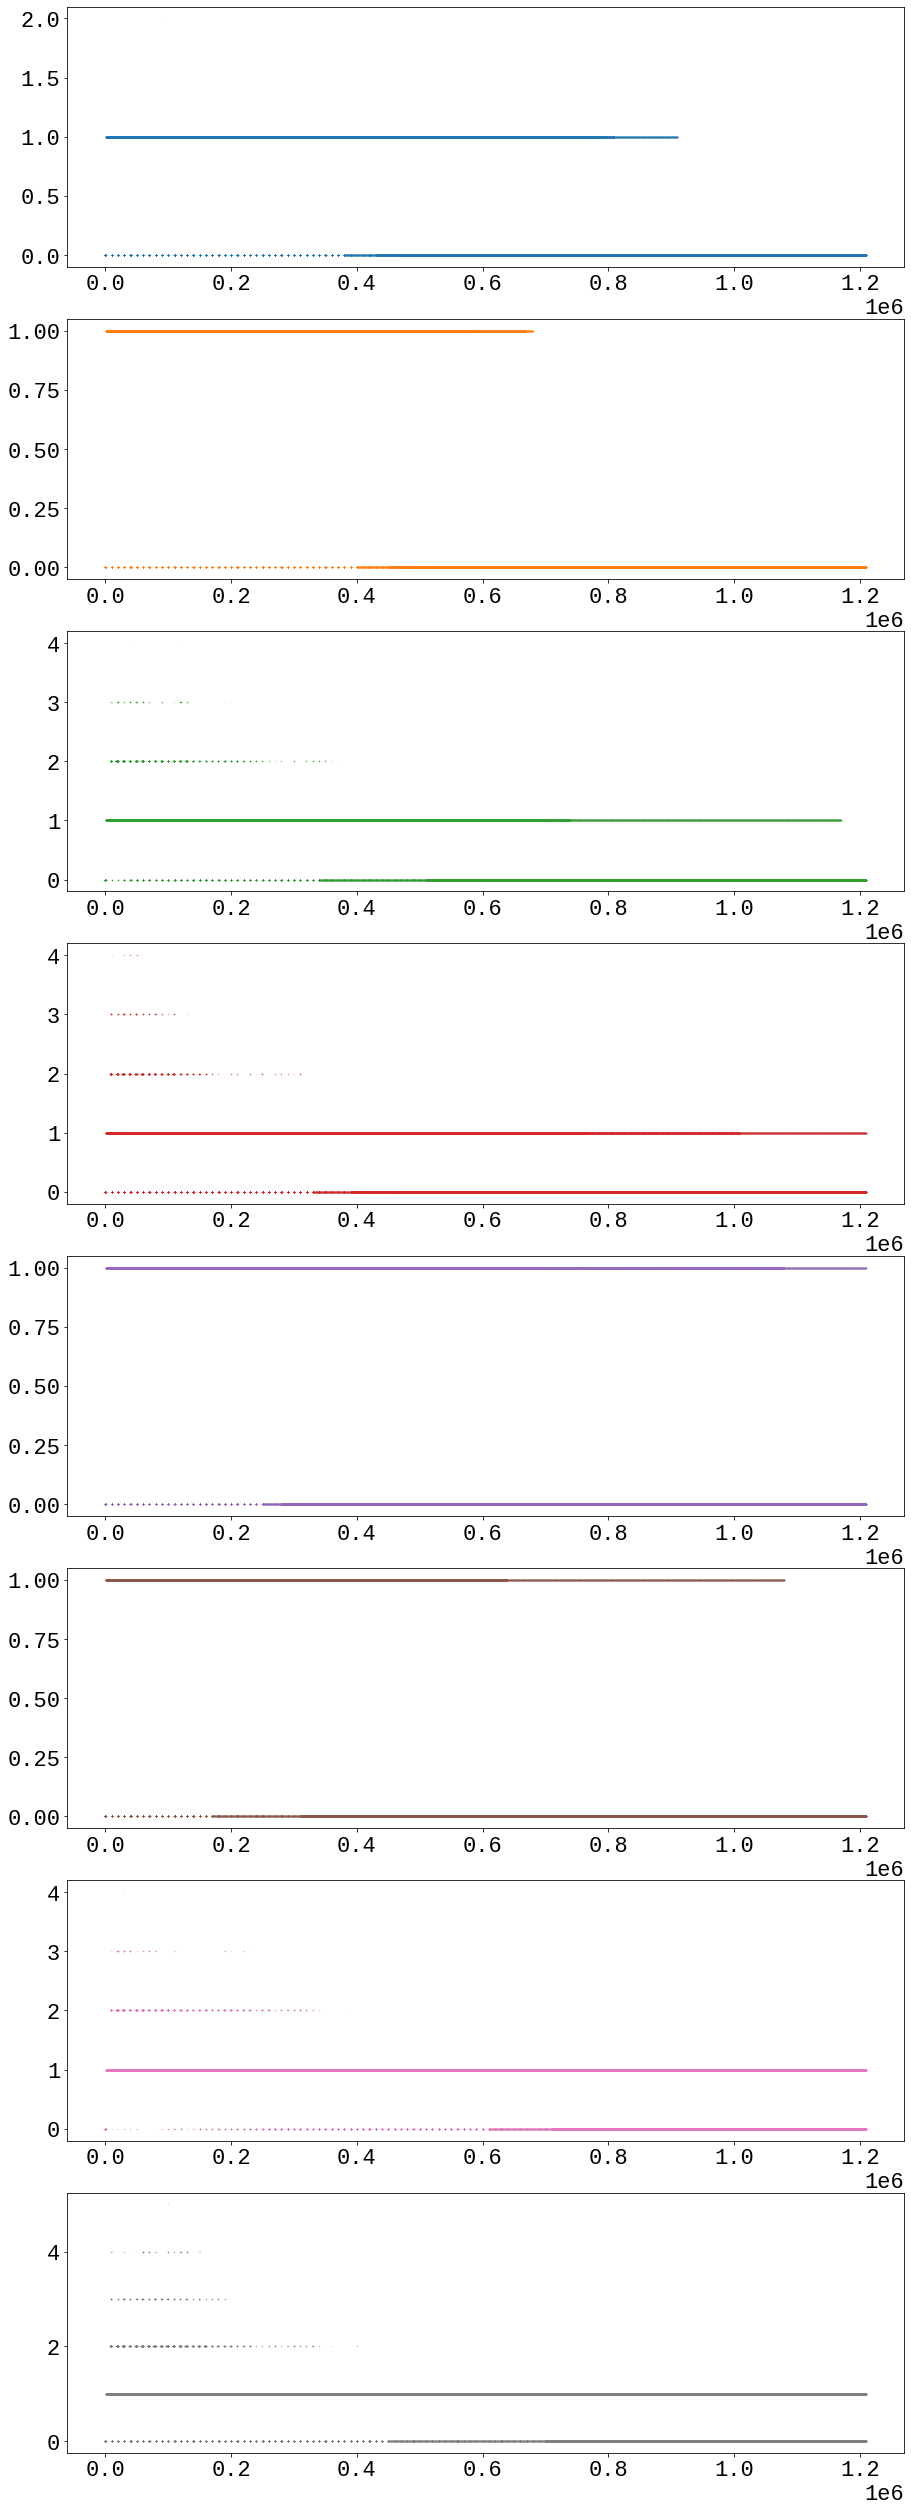

In [25]:
fig, axes = plt.subplots(8, 1, figsize=(15,45))

for i in range(n_files):
    process, repeat, prms = params[i]
    process = int(process)
#     print(process, repeat)
    _=axes[process].scatter(sample_idxs, depth_samples[:,i], 
                            marker='.',
                            s=.5,
                            color=colors[color_keys[int(process)]], 
                            alpha=.1
                           )

## Beginning and end rewards

In [26]:
nf=n_files
ns=1000

In [27]:
begin_rewards = np.zeros((ns,nf))
end_rewards = np.zeros((ns,nf))
for i in range(nf):
    b = reward_samples[(reward_samples[:,i] > 0.0),i][:ns]
    e = reward_samples[(reward_samples[:,i] > 0.0),i][-ns:]
    if e.shape[0] == ns:
        begin_rewards[:,i]=b
        end_rewards[:,i]=e

Text(0, 0.5, 'Number of models')

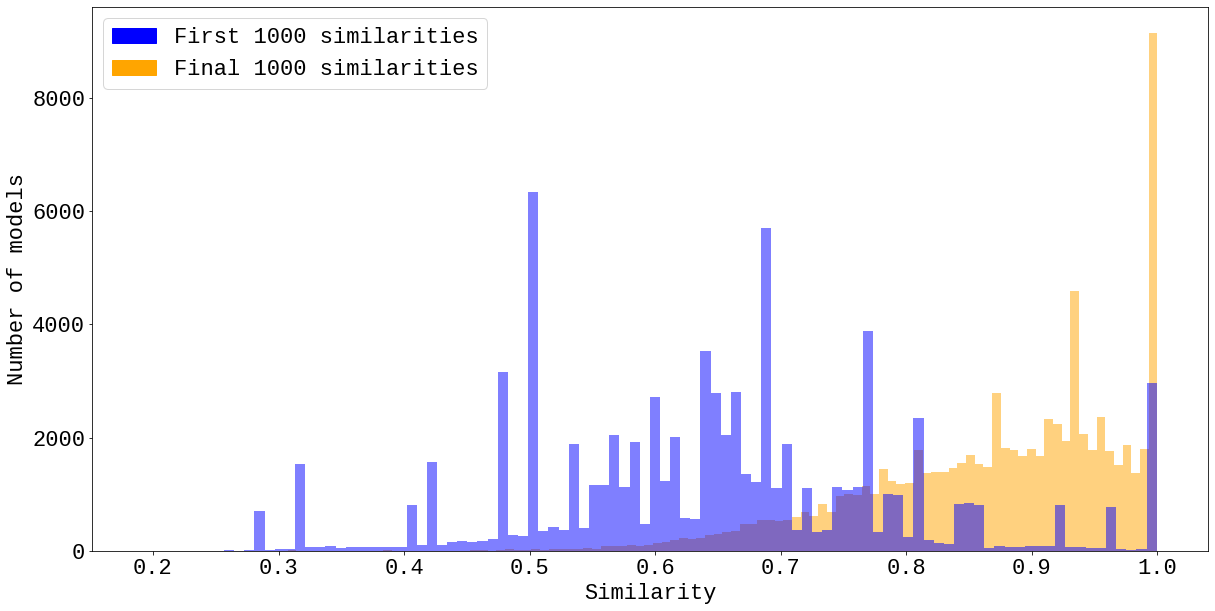

In [948]:
fig = plt.figure(figsize=(20,10))
ax = plt.axes()
_=plt.hist(end_rewards.flatten(), bins=100, color='orange', alpha=.5)
_=plt.hist(begin_rewards.flatten(), bins=100, color='blue', alpha=.5)

patches = [mpatches.Patch(color='blue', label='First 1000 similarities'),
           mpatches.Patch(color='orange', label='Final 1000 similarities')]
_=plt.legend(handles=patches)
ax.set_xlabel('Similarity')
ax.set_ylabel('Number of models')

Text(0, 0.5, 'Number of models')

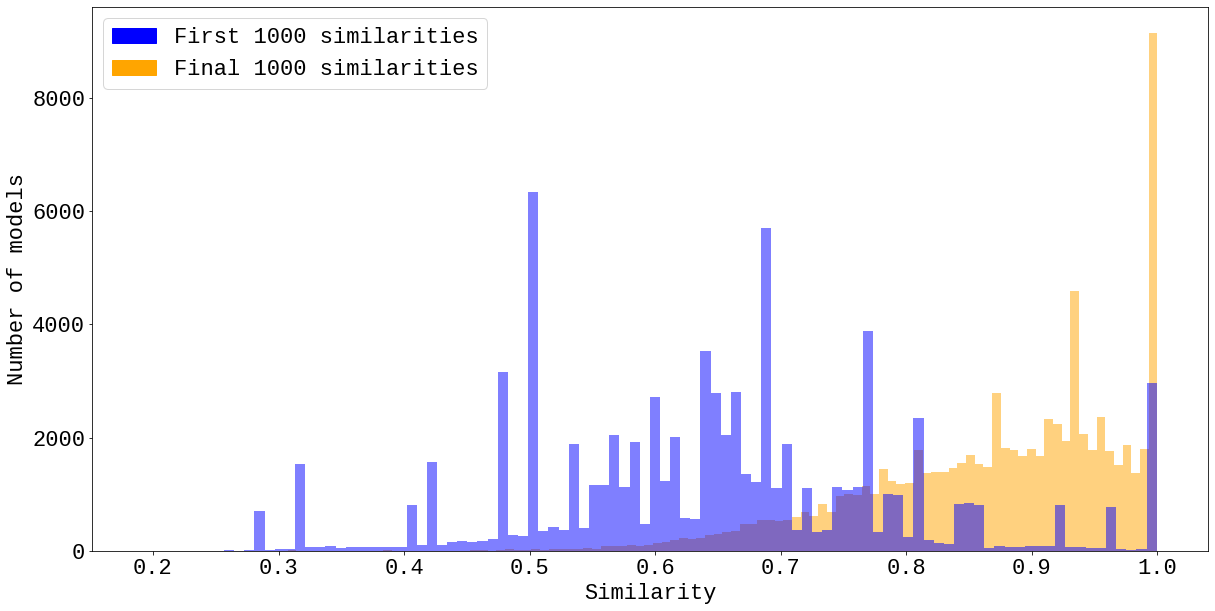

In [948]:
fig = plt.figure(figsize=(20,10))
ax = plt.axes()
_=plt.hist(end_rewards.flatten(), bins=100, color='orange', alpha=.5)
_=plt.hist(begin_rewards.flatten(), bins=100, color='blue', alpha=.5)

patches = [mpatches.Patch(color='blue', label='First 1000 similarities'),
           mpatches.Patch(color='orange', label='Final 1000 similarities')]
_=plt.legend(handles=patches)
ax.set_xlabel('Similarity')
ax.set_ylabel('Number of models')

## Analysis of sampled models

### Load data

In [830]:
models_8 = pickle.load(open(f'{data_dir}/inputs/models_sync_{8}_20201215_123542.pickle','rb'))
models_16 = pickle.load(open(f'{data_dir}/inputs/models_sync_{16}_20201215_123542.pickle','rb'))
models_32 = pickle.load(open(f'{data_dir}/inputs/models_sync_{32}_20201215_123542.pickle','rb'))

In [835]:
models = models_8 | models_16 | models_32

In [838]:
attractors_8 = pickle.load(open(f'{data_dir}/inputs/attractors_sync_{8}_20201215_123542.pickle','rb'))
attractors_16 = pickle.load(open(f'{data_dir}/inputs/attractors_sync_{16}_20201215_123542.pickle','rb'))
attractors_32 = pickle.load(open(f'{data_dir}/inputs/attractors_sync_{32}_20201215_123542.pickle','rb'))

In [839]:
attractors = attractors_8 | attractors_16 | attractors_32

In [845]:
start_states_8 = pickle.load(open(f'{data_dir}/inputs/start_states_sync_{8}_20201215_123542.pickle','rb'))
start_states_16 = pickle.load(open(f'{data_dir}/inputs/start_states_sync_{16}_20201215_123542.pickle','rb'))
start_states_32 = pickle.load(open(f'{data_dir}/inputs/start_states_sync_{32}_20201215_123542.pickle','rb'))

In [846]:
start_states = start_states_8 | start_states_16 | start_states_32

In [885]:
from statistics import median, mean, stdev as std

### Attractor count

In [901]:
for numnodes, attrs in attractors.items():
    stables, cyclics = attrs
    nstable = []
    ncyclic = []
    lcyclic = []
    for i in range(len(stables)):
        stable = stables[i]
        cyclic = cyclics[i]
        nstable.append(len(stable))
        ncyclic.append(len(cyclic))
        lcyclic += [len(cycle) for cycle in cyclic]
    print(f'{numnodes:2d} species & {mean(nstable):.1f}\pm{std(nstable):.2f} & {median(nstable):.2f} \
& {mean(ncyclic):.2f}\pm{std(ncyclic):.2f} \
& {median(ncyclic):.2f} & {mean(lcyclic):.2f}\pm{std(lcyclic):.2f} \\\\')


 8 species & 2.6\pm1.11 & 3.00 & 2.90\pm1.75 & 3.00 & 2.65\pm0.91 \\
16 species & 2.4\pm1.30 & 2.00 & 3.59\pm2.47 & 3.00 & 3.37\pm1.91 \\
32 species & 2.4\pm1.39 & 2.00 & 4.42\pm2.72 & 4.00 & 5.36\pm6.83 \\


### Cyclic length

In [890]:
for numnodes, attrs in attractors.items():
    stables, cyclics = attrs
    lcyclic = []
    for i in range(len(stables)):
        stable = stables[i]
        cyclic = cyclics[i]
        nstable.append(len(stable))
        ncyclic.append(len(cyclic))
    print(f'{numnodes:2d} species {mean(nstable):.1f}±{std(nstable):.2f} {median(nstable):.2f} {mean(ncyclic):.2f}±{std(ncyclic):.2f} {median(ncyclic):.2f}')


 8 species 2.6±1.11 3.00 2.90±1.75 3.00
16 species 2.4±1.30 2.00 3.59±2.47 3.00
32 species 2.4±1.39 2.00 4.42±2.72 4.00


### Attractor 0-1 count

In [888]:
for numnodes, attrs in attractors.items():
    stables, cyclics = attrs
    cstable = [0 for i in range(len(stables))]
    ccyclic = [0 for i in range(len(stables))]
    for i in range(len(stables)):
        stable = stables[i]
        cyclic = cyclics[i]
        for state in stable:
            for node,value in state:
                cstable[i]+=value
            cstable[i]= cstable[i]/len(state)
            
        for cycle in cyclic:
            for state in cycle:
                for node,value in state:
                    ccyclic[i]+=value
            ccyclic[i]= ccyclic[i]/(len(state)*len(cycle))
    print(f'{numnodes:2d} species {mean(cstable):.1f}±{std(cstable):.2f} {median(cstable):.2f} {mean(ccyclic):.2f}±{std(ccyclic):.2f} {median(ccyclic):.2f}')


 8 species 0.3±0.27 0.33 0.33±0.20 0.30
16 species 0.2±0.21 0.19 0.28±0.17 0.30
32 species 0.2±0.20 0.15 0.30±0.15 0.30


### Start State 0-1 count

In [889]:
for numnodes, starts in start_states.items():
    c = [0 for i in range(len(starts))]
    for i,start in enumerate(starts):
        for state in start:
            for node,value in state.items():
                c[i]+=value
                
        c[i]= c[i]/(len(start)*numnodes)

    print(f'{numnodes:2d} species {mean(c):.1f}±{std(c):.2f} {median(c):.2f}')


 8 species 0.5±0.10 0.47
16 species 0.4±0.16 0.43
32 species 0.4±0.18 0.41


## Best results 

In [909]:
_,_,log_files = next(os.walk(f'{data_dir}/logs'))

In [924]:
bests = {nn:[] for nn in [8,16,32]}
re_best = re.compile('best reward (.*)')

for f in log_files:
    best = 0.0
    nn = int(re.split('[_-]',f)[3])
    for line in open(f'{data_dir}/logs/{f}'):
        match = re_best.match(line)
        if match:
            reward = float(match.groups()[0])
            if reward > best:
                best = reward
    bests[nn].append(best)

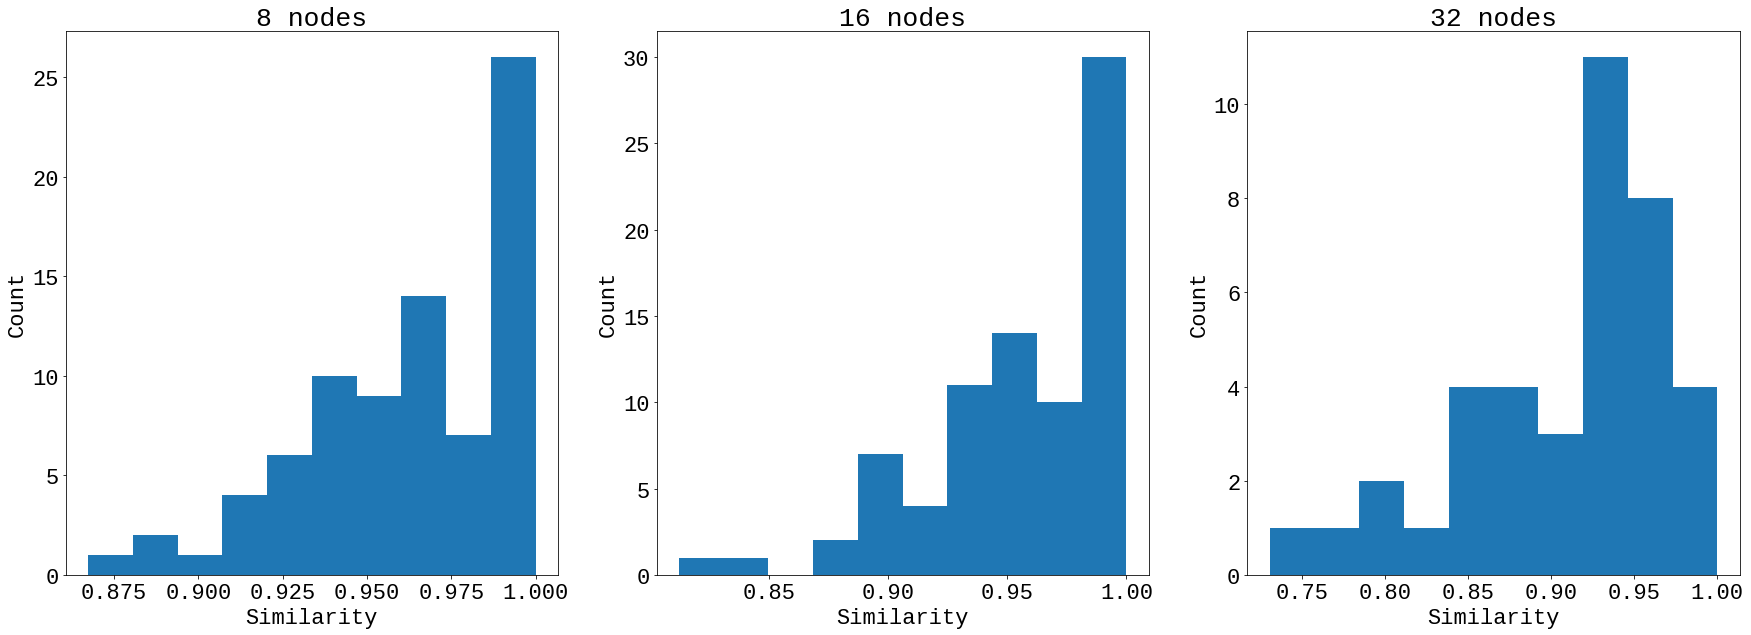

In [938]:
i=1
plt.figure(figsize=(30,10))
for nn in bests:
    ax = plt.subplot(1,3,i)
    ax.set_title(f'{nn} nodes')
    ax.set_xlabel('Similarity')
    ax.set_ylabel('Count')
    i+=1
    plt.hist(bests[nn])